# 5LSM0 Graded Assignment 2: Cityscapes Baseline

For this assignment, you will create a baseline for the [Cityscapes Pixel-Level Segmentation Benchmark](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task)! You will do this in **groups of two students**. The goal is to create a network that performs semantic segmentation on the Cityscapes dataset. This dataset is a large collection of pictures taken from the perspective of a driver in various German cities. Each picture has a corresponding ground-truth image, where each pixel is given a color that corresponds to the class of the object appearing in that pixel. The table below shows the expected input and output of the solution you will be creating.

<table>
<thead>
    <tr><th>Input</th><th>Output</th></tr>
</thead>
<tbody>
    <tr>
        <td>
            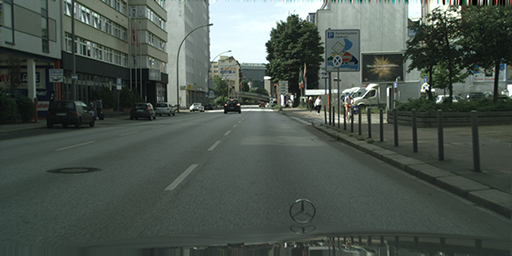
        </td>
        <td>
        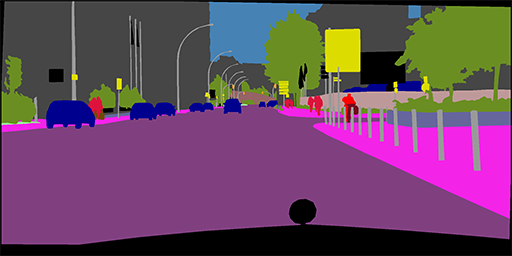
        </td>
    </tr>
    <tr>
        <td>Picture from the Cityscapes dataset.</td>
        <td>Semantic class assigned to each pixel. Every unique color corresponds to one class.</td>
    </tr>
</tbody>
</table>

This assignment determines 10% of your final grade, and is also a warm-up for the final assignment, where you will be challenged with a harder task! You can use the outcome of this assignment as a starting point.

Training your neural network will likely take many hours, take this into account when making your working schedule. This notebook downloads the required data for the benchmark and sets up a training pipeline so you can focus on creating networks using the skills you learned during this course. Some exercises have been included to get you started. Join us during computer class or message an assistant if you have any questions.


## Deliverables

First, submit this template with your code to Canvas when you're finished.

Second, you have to submit your model for a first evaluation at phase 1 of our own competition server. More about this later in the assignment.

## Requirements

You need at least Python version 3.7. The prefered library for creating your network is PyTorch. All third-party packages you need to run this notebook are imported below, such that you can install any missing dependencies before getting started.

In [2]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

%matplotlib inline


## Downloading and preprocessing the ground truth and input files
Let's start with downloading a ZIP-file that contains the training, testing and validation datasets.

In [3]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://filesender.surf.nl/download.php?token=d9146b2e-5982-472a-9c41-1f5652d39f38&files_ids=13213593'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://filesender.surf.nl/download.php?token=07dc545a-c9f4-4a02-a181-7235849ad47c&files_ids=13213595'
dir_input = os.path.join(dir_data, "leftImg8bit")
# dir_data = "D:/荷兰/TUe/课程/Q3/5LSM0/Assignment 3/data/data"

# dir_truth = os.path.join(dir_data, "gtFine")
# dir_input = os.path.join(dir_data, "leftImg8bit")


# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()

        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')

# Done!
print(f'All data downloaded')




Directory does not exist: /content/data/gtFine
Downloading: https://filesender.surf.nl/download.php?token=d9146b2e-5982-472a-9c41-1f5652d39f38&files_ids=13213593
Progress: 100.00 %
Unpacking archive.
Directory does not exist: /content/data/leftImg8bit
Downloading: https://filesender.surf.nl/download.php?token=07dc545a-c9f4-4a02-a181-7235849ad47c&files_ids=13213595
Progress: 100.00 %
Unpacking archive.
All data downloaded


The downloaded images are very large. A consumer-grade PC likely does not have enough GPU-memory or data bandwidth to create a viable implementation in the original size. For this reason, we run a pre-processing step on the dataset that downscales all images. Once you have a working model, you may consider using a larger `sample_size`.

In [4]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue

    print(f'Preprocessing: {dir_full}')

    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue

        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')

        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)

        for f in files:
            if not f.endswith('.png'):
                continue

            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)

print(f'Preprocessing done')


Preprocessing: /content/data/gtFine
Preprocessing sub-directory: /val/munster
Preprocessing sub-directory: /val/frankfurt
Preprocessing sub-directory: /val/lindau
Preprocessing sub-directory: /train/hanover
Preprocessing sub-directory: /train/cologne
Preprocessing sub-directory: /train/bochum
Preprocessing sub-directory: /train/darmstadt
Preprocessing sub-directory: /train/weimar
Preprocessing sub-directory: /train/hamburg
Preprocessing sub-directory: /train/zurich
Preprocessing sub-directory: /train/ulm
Preprocessing sub-directory: /train/aachen
Preprocessing sub-directory: /train/monchengladbach
Preprocessing sub-directory: /train/dusseldorf
Preprocessing sub-directory: /train/strasbourg
Preprocessing sub-directory: /train/bremen
Preprocessing sub-directory: /train/krefeld
Preprocessing sub-directory: /train/erfurt
Preprocessing sub-directory: /train/stuttgart
Preprocessing sub-directory: /train/tubingen
Preprocessing sub-directory: /train/jena
Preprocessing: /content/data/leftImg8bi

## Data structures

Now that our data has been downloaded, we can proceed to define some data structures to model the structure of the provided data. Each semantic class that we aim to detect has a unique name, id and color. For more information on the datset, view [this link](https://www.cityscapes-dataset.com/dataset-overview/). For this assigment we expect your model to output just for the classes used for evaluation.

In [5]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str

    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))

    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))


# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str       # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    ID: int         # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    trainId: int    # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    category: str   # The name of the category that this label belongs to

    categoryId: int # The ID of this category. Used to create ground truth images
                    # on category level.

    hasInstances: bool # Whether this label distinguishes between single instances or not

    ignoreInEval: bool # Whether pixels having this class as ground truth label are ignored
                       # during evaluations or not

    color: Tuple[int, int, int]       # The color of this label


# List of classes that we want to detect in the input
classes = [
    #                 name                     ID    trainId   category            catId     hasInstances   ignoreInEval   color
    CityscapesClass(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    CityscapesClass(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    CityscapesClass(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    CityscapesClass(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    CityscapesClass(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    CityscapesClass(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    CityscapesClass(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    CityscapesClass(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    CityscapesClass(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    CityscapesClass(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    CityscapesClass(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    CityscapesClass(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    CityscapesClass(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    CityscapesClass(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (0  ,  0,  0) ),
    CityscapesClass(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    CityscapesClass(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    CityscapesClass(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    CityscapesClass(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    CityscapesClass(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    CityscapesClass(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    CityscapesClass(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    CityscapesClass(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    CityscapesClass(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    CityscapesClass(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    CityscapesClass(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    CityscapesClass(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    CityscapesClass(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    CityscapesClass(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    CityscapesClass(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    CityscapesClass(  'license plate'        , -1 ,      255 , 'vehicle'         , 7       , False        , True         , (0  ,0  ,  0) ),
]


## Dataset implementation

This section implements a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). It transforms image and target colorization pairs from the downloaded files into pairs of input and ground truth tensors. The ground truths are single-channel images where the value of each pixel is equal to the ID of the class represented by the color in the target. This will enable us to train the network using cross-entropy. 

The Cityscapes dataset is split in three parts: `train`, `val` and `test`. If everything is set-up correctly, we should be able to draw a random sample from each split, convert it back to an image, and display it.

In [6]:
import numpy as np
import os
import torchvision
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
import random

import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()

        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        # Data Argumentation
        if self.dir_input == os.path.join(dir_input_pp, 'train'):
            # Horizontal flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomHorizontalFlip(p=1)(img)
                mask = torchvision.transforms.RandomHorizontalFlip(p=1)(mask)
            
            # Vertical flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomVerticalFlip(p=1)(img)
                mask = torchvision.transforms.RandomVerticalFlip(p=1)(mask)
            
            # Random rotation
            if random.random() <= 0.3:
                angle = random.randint(-30, 30)
                img = torchvision.transforms.functional.rotate(img, angle)
                mask = torchvision.transforms.functional.rotate(mask, angle)
            
            # Brightness adjustment
            if random.random() <= 0.3:
                img = torchvision.transforms.functional.adjust_brightness(img, random.random() + 0.5)

            # Colour dithering
            if random.random() <= 0.3:
                color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
                img = color_jitter(img)
        ################################################################################# 
        # Convert the image to a tensor
        img = TF.to_tensor(img)

        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target[eq] = c.trainId    
            
        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val")
}



Subset,Amount,Size,Input sample,Truth sample
train,2975,256×128,,
val,500,256×128,,

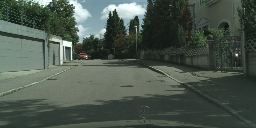
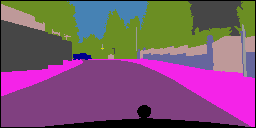
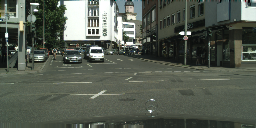
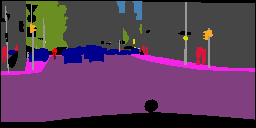

In [7]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    #print(torch.unique(truth))

    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)

    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth:
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


Notice that the `test` set has no ground truth labels, as this is the set used to score competitors' networks against each other. If you submit the best network that you have created to the Cityscapes competition, this is the set that is used to calculate your score.

## Calculating accuracy
Your score on the benchmark will be calculated according to the the intersection-over-union (IoU) metric. [This link](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task) describes how it is implemented in the testing suite. 

The function below is thus a measure for the accuracy of your solution. The `output` parameter represents the output of your network: a batch of multi-dimensional images with one channel per class. For every pixel, the class ID can be calculated by taking the index of the channel containing the maximum value. The `truths` parameter is a batch of ground truths from the `CityscapesDataset` defined above.

In [8]:
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    output = output.detach().cpu()
    truths = truths.detach().cpu()

    ## EXERCISE #####################################################################
    #
    # Implement the IoU metric that is used by the benchmark to grade your results.
    #     
    # `output` is a tensor of dimensions [Batch, Classes, Height, Width]
    # `truths` is a tensor of dimensions [Batch, Height, Width]
    #
    # Tip: Peform a sanity check that tests your implementation on a user-defined 
    #      tensor for which you know what the output should be.
    #
    ################################################################################# 
    # Sanity check
    assert(
        len(output.size()) == 4,
        output.size(dim=0) == truths.size(dim=0),
        output.size(dim=1) == len(classes),
        output.size(dim=2) == truths.size(dim=1),
        output.size(dim=3) == truths.size(dim=2),
        f"Output is not in the right shape")
    id_list = []
    cat_dict = {}
    for c in classes:
       if c.ignoreInEval == True:
          continue
       if c.trainId not in id_list:
          id_list.append(c.trainId)
       if c.categoryId not in cat_dict.keys():
          cat_dict[c.categoryId] = [c.trainId]
       else:
          cat_dict[c.categoryId].append(c.trainId)
          
    output = torch.argmax(output,dim=1)
    sum_iou = 0
    class_present = 0
    for cat in cat_dict:
       cat_output = (output == -1)
       cat_truth = (truths == -1)
       for c in cat_dict[cat]:
          cat_output += (output == c)
          cat_truth += (truths == c)
       tp = torch.logical_and(cat_output,cat_truth).sum()
       fn = torch.logical_and((cat_output != 1),cat_truth).sum()
       fp = torch.logical_and(cat_output,(cat_truth != 1)).sum()
       if tp + fp == 0: # omit the class if it was not present for that batch
            continue
       if (2*tp+fn+fp)>0:
            sum_iou += 2*tp/(2*tp+fn+fp)
            class_present += 1
    if class_present != 0:
      iou = (sum_iou/class_present).float()
    else:
      iou = 0
    #################################################################################

    return iou

<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-8-e6001a66694e>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(


## Training setup
The final step before you can implement your networks is to define the training process.

In [9]:
from torch import nn, optim
from torch.utils.data import DataLoader
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset]):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        # Move the model onto the target device
        self.model = model.to(self.device)

        # Store the dataset split
        self.ds_split = ds_split

        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 

        self.optimizer = optim.Adam(model.parameters(), lr=0.0001)
         # Add a learning rate scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=7, factor=0.1)
        # self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.1

        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 

        self.critereon = nn.CrossEntropyLoss(ignore_index=255)
        ################################################################################# 

        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"

    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()

        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()

                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                self.optimizer.step()

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)

        sys.stdout.flush()

        # Return metrics
        return epoch_metrics

    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()

        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0

        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()

        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')

        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }




    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(self.ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(self.ds_split["val"], batch_size=batch_size, drop_last=True)

        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()

         # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
           print(f'Epoch {epoch}')
           metrics_train = self.train_epoch(dl_train)
           df_train = pd.concat([df_train, pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train})], ignore_index=True)

           metrics_val = self.val_epoch(dl_val)
           df_val = pd.concat([df_val, pd.DataFrame({'epoch': [epoch], **metrics_val})], ignore_index=True)

           # Compute the mean validation loss
           val_loss = pd.Series(metrics_val["loss"]).mean()

           # Update the learning rate scheduler with the validation loss
           self.scheduler.step(val_loss)

        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


    # def fit(self, epochs: int, batch_size:int):
    #     # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
    #     # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
    #     dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
    #     dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)

    #     # Store metrics of the training process (plot this to gain insight)
    #     df_train = pd.DataFrame()
    #     df_val = pd.DataFrame()

    #     # Train the model for the provided amount of epochs
    #     for epoch in range(1, epochs+1):
    #         print(f'Epoch {epoch}')
    #         metrics_train = self.train_epoch(dl_train)
    #         df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)

    #         metrics_val = self.val_epoch(dl_val)
    #         df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)

    #     # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
    #     return df_train, df_val


If the section above ran without errors, then you are ready to continue.

## Define a baseline
You should start by implementing a network that performs semantic segmentation reasonably well (e.g. [U-Net](https://arxiv.org/pdf/1505.04597.pdf)). This will be the baseline against which you can compare your own improvements in the final assignment.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet152

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

class ASPPConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, dilation, separable=False):
        if separable:
            conv_layer1 = SeparableConv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False)
            conv_layer2 = SeparableConv2d(out_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False)
        else:
            conv_layer1 = nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False)
            conv_layer2 = nn.Conv2d(out_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False)

        modules = [
            conv_layer1,
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            conv_layer2,
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        super(ASPPConv, self).__init__(*modules)


class ASPPPooling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPPPooling, self).__init__()
        self.pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.pool(x)

class ImprovedASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates_list, separable=False):
        super(ImprovedASPP, self).__init__()
        self.aspp_modules = nn.ModuleList()

        for atrous_rates in atrous_rates_list:
            modules = []
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)))

            for rate in atrous_rates:
                modules.append(ASPPConv(in_channels, out_channels, rate, separable))

            modules.append(ASPPPooling(in_channels, out_channels))
            aspp_module = nn.ModuleList(modules)
            self.aspp_modules.append(aspp_module)

        self.project = nn.Sequential(
            nn.Conv2d(len(atrous_rates_list) * (len(atrous_rates_list[0]) + 2) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5))


    def forward(self, x):
        res = []
        for aspp_module in self.aspp_modules:
            res_per_module = []
            for aspp in aspp_module:
                res_per_module.append(aspp(x))

            # Upsample ASPPPooling result before concatenating
            res_per_module[-1] = F.interpolate(res_per_module[-1], size=res_per_module[-2].size()[2:], mode='bilinear', align_corners=True)
            
            if res_per_module:
                res.append(torch.cat(res_per_module, dim=1))
            

        res = torch.cat(res, dim=1)
        return self.project(res)


class Model(nn.Module):
    def __init__(self, in_channels=3):
        super(Model, self).__init__()
        self.backbone = resnet152(pretrained=True)
        self.aspp = ImprovedASPP(2048, 256, atrous_rates_list=[(6, 12, 18), (12, 18, 24)])
        self.decoder = DeepLabPlusDecoder(256, 20)
        
        self.backbone.layer4[0].conv2.stride = (1, 1)
        self.backbone.layer4[0].downsample[0].stride = (1, 1)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        low_level_features = x
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.aspp(x)
        x = self.decoder(x, low_level_features)

        return x

class DeepLabPlusDecoder(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DeepLabPlusDecoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 48, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU(inplace=True)
        self.last_conv = nn.Sequential(
          nn.Conv2d(in_channels + 48, 256, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(256),
          nn.ReLU(inplace=True),
          nn.Dropout(0.5),
          nn.Conv2d(256, num_classes, kernel_size=1)
        )



    def forward(self, x, low_level_features):
        low_level_features = self.conv1(low_level_features)
        low_level_features = self.bn1(low_level_features)
        low_level_features = self.relu(low_level_features)
        
        x = F.interpolate(x, size=low_level_features.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_features), dim=1)
        x = self.last_conv(x)

        # Add upsampling step to match the target tensor size
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        
        return x



/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 249MB/s]


Testing training process...
Epoch 1


Validation: 100%|██████████| 500/500 [00:09<00:00, 50.82it/s, accuracy=tensor(0.6502), loss=0.771]

Validation loss is 0.011255332624912262, validation accuracy is 0.7181456089019775
Epoch 2



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.03it/s, accuracy=tensor(0.5809), loss=0.613]

Validation loss is 0.009511569130420686, validation accuracy is 0.7273976802825928
Epoch 3



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.29it/s, accuracy=tensor(0.5922), loss=0.658]

Validation loss is 0.008829934918880462, validation accuracy is 0.6728916168212891
Epoch 4



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.67it/s, accuracy=tensor(0.6187), loss=0.449]

Validation loss is 0.00796795175075531, validation accuracy is 0.6866726875305176
Epoch 5



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.84it/s, accuracy=tensor(0.6185), loss=0.496]

Validation loss is 0.00812888081073761, validation accuracy is 0.698000967502594
Epoch 6



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.88it/s, accuracy=tensor(0.6298), loss=0.511]


Validation loss is 0.007658930027484894, validation accuracy is 0.7014040350914001
Epoch 7


Validation: 100%|██████████| 500/500 [00:09<00:00, 50.66it/s, accuracy=tensor(0.6301), loss=0.479]

Validation loss is 0.007632580661773681, validation accuracy is 0.6994237303733826
Epoch 8



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.28it/s, accuracy=tensor(0.6337), loss=0.445]

Validation loss is 0.0073106255292892455, validation accuracy is 0.7113987803459167
Epoch 9



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.58it/s, accuracy=tensor(0.6343), loss=0.449]

Validation loss is 0.007226284229755402, validation accuracy is 0.7132976055145264
Epoch 10



Validation: 100%|██████████| 500/500 [00:10<00:00, 49.66it/s, accuracy=tensor(0.6396), loss=0.459]

Validation loss is 0.007515701586008072, validation accuracy is 0.7196115255355835
Epoch 11



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.72it/s, accuracy=tensor(0.6478), loss=0.533]

Validation loss is 0.007491543394327164, validation accuracy is 0.7162176370620728
Epoch 12



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.26it/s, accuracy=tensor(0.6433), loss=0.434]

Validation loss is 0.007260055714845657, validation accuracy is 0.7201990485191345
Epoch 13



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.69it/s, accuracy=tensor(0.6453), loss=0.509]

Validation loss is 0.007230960410833359, validation accuracy is 0.7275547981262207
Epoch 14



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.33it/s, accuracy=tensor(0.6423), loss=0.412]

Validation loss is 0.006879461050033569, validation accuracy is 0.723025918006897
Epoch 15



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.92it/s, accuracy=tensor(0.6604), loss=0.424]

Validation loss is 0.007019097739458084, validation accuracy is 0.7282457947731018
Epoch 16



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.52it/s, accuracy=tensor(0.6448), loss=0.418]

Validation loss is 0.007172709101438523, validation accuracy is 0.7253706455230713
Epoch 17



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.55it/s, accuracy=tensor(0.6570), loss=0.481]

Validation loss is 0.006731846171617508, validation accuracy is 0.7358355522155762
Epoch 18



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.25it/s, accuracy=tensor(0.6549), loss=0.478]

Validation loss is 0.006797850453853607, validation accuracy is 0.7293475270271301
Epoch 19



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.47it/s, accuracy=tensor(0.6612), loss=0.415]

Validation loss is 0.006564407229423523, validation accuracy is 0.7341622710227966
Epoch 20



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.31it/s, accuracy=tensor(0.6658), loss=0.408]

Validation loss is 0.006890005195140838, validation accuracy is 0.7315911054611206
Epoch 21



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.35it/s, accuracy=tensor(0.6472), loss=0.473]

Validation loss is 0.006829355996847153, validation accuracy is 0.7310822010040283
Epoch 22



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.53it/s, accuracy=tensor(0.6648), loss=0.59]

Validation loss is 0.007271985536813737, validation accuracy is 0.729814887046814
Epoch 23



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.55it/s, accuracy=tensor(0.6481), loss=0.534]


Validation loss is 0.006677298057079315, validation accuracy is 0.7404139041900635
Epoch 24


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.56it/s, accuracy=tensor(0.6568), loss=0.467]

Validation loss is 0.006749792563915252, validation accuracy is 0.7398577928543091
Epoch 25



Validation: 100%|██████████| 500/500 [00:09<00:00, 52.09it/s, accuracy=tensor(0.6672), loss=0.44]

Validation loss is 0.006566093868017197, validation accuracy is 0.7422374486923218
Epoch 26



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.97it/s, accuracy=tensor(0.6593), loss=0.458]

Validation loss is 0.006490910512208938, validation accuracy is 0.739763081073761
Epoch 27



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.28it/s, accuracy=tensor(0.6601), loss=0.394]

Validation loss is 0.0066184298813343045, validation accuracy is 0.7388973236083984
Epoch 28



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.21it/s, accuracy=tensor(0.6653), loss=0.471]

Validation loss is 0.0070712564706802376, validation accuracy is 0.7378326654434204
Epoch 29



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.22it/s, accuracy=tensor(0.6494), loss=0.504]


Validation loss is 0.006569341766834259, validation accuracy is 0.7409011721611023
Epoch 30


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.13it/s, accuracy=tensor(0.6678), loss=0.469]

Validation loss is 0.006464196360111236, validation accuracy is 0.7415953874588013
Epoch 31



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.67it/s, accuracy=tensor(0.6557), loss=0.469]

Validation loss is 0.006563851541280747, validation accuracy is 0.7451992034912109
Epoch 32



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.47it/s, accuracy=tensor(0.6725), loss=0.508]

Validation loss is 0.006580218863487244, validation accuracy is 0.7444330453872681
Epoch 33



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.07it/s, accuracy=tensor(0.6783), loss=0.548]

Validation loss is 0.006559332197904587, validation accuracy is 0.7452966570854187
Epoch 34



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.19it/s, accuracy=tensor(0.6605), loss=0.533]

Validation loss is 0.006723518216609955, validation accuracy is 0.7443886399269104
Epoch 35



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.05it/s, accuracy=tensor(0.6781), loss=0.498]

Validation loss is 0.006646919351816177, validation accuracy is 0.749976634979248
Epoch 36



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.95it/s, accuracy=tensor(0.6775), loss=0.417]

Validation loss is 0.006605129247903824, validation accuracy is 0.7452758550643921
Epoch 37



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.49it/s, accuracy=tensor(0.6784), loss=0.451]

Validation loss is 0.006712582474946976, validation accuracy is 0.7422636151313782
Epoch 38



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.67it/s, accuracy=tensor(0.6673), loss=0.432]


Validation loss is 0.006503553175926209, validation accuracy is 0.7512391805648804
Epoch 39


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.35it/s, accuracy=tensor(0.6782), loss=0.41]

Validation loss is 0.006317037707567214, validation accuracy is 0.7522154450416565
Epoch 40



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.44it/s, accuracy=tensor(0.6785), loss=0.445]


Validation loss is 0.006337630677223206, validation accuracy is 0.7541916370391846


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 20, 128, 256]",
Target,"[128, 256]",

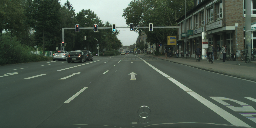
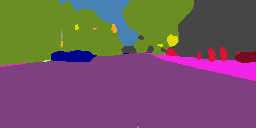
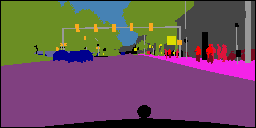

In [11]:
model = Model()

# Train the DeepLabV3+ model
print("Testing training process...")
trainer = Trainer(model, ds_split)
df_train, df_val = trainer.fit(epochs=40, batch_size=10)

from pathlib import Path
filepath = Path('df_train_crossEntropy_1.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train.to_csv(filepath)  

filepath = Path('df_val_crossEntropy_1.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_val.to_csv(filepath)  

# Save the trained model
torch.save(model.state_dict(), 'deeplabv3plus_1.pth')

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b:
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))




**Rain**

In [12]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209843'
dir_truth = os.path.join(dir_data, "raintruth")

url_input = 'https://filesender.surf.nl/download.php?token=f76f4413-d105-4069-b773-557dd6109623&files_ids=13213195'
dir_input = os.path.join(dir_data, "rainimage")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()

        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')

# Done!
print(f'All data downloaded')


Directory does not exist: /content/data/raintruth
Downloading: https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209843
Progress: 100.00 %
Unpacking archive.
Directory does not exist: /content/data/rainimage
Downloading: https://filesender.surf.nl/download.php?token=f76f4413-d105-4069-b773-557dd6109623&files_ids=13213195
Progress: 100.00 %
Unpacking archive.
All data downloaded


In [16]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue

    print(f'Preprocessing: {dir_full}')

    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue

        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')

        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)

        for f in files:
            if not f.endswith('.png'):
                continue

            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)

print(f'Preprocessing done')

Preprocessed directory already exists: /content/data/raintruth_256_128
Preprocessing: /content/data/rainimage
Preprocessing sub-directory: /val/munster
Preprocessing sub-directory: /val/lindau
Preprocessing sub-directory: /train/hanover
Preprocessing sub-directory: /train/cologne
Preprocessing sub-directory: /train/bochum
Preprocessing sub-directory: /train/weimar
Preprocessing sub-directory: /train/aachen
Preprocessing sub-directory: /train/dusseldorf
Preprocessing sub-directory: /train/bremen
Preprocessing sub-directory: /train/erfurt
Preprocessing sub-directory: /train/jena
Preprocessing done


In [17]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    alpha: str = ""
    beta: str = ""
    dropsize: str = ""
    pattern:str = ""

    @property
    def id(self):
      if self.alpha != "":
          return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id, "leftImg8bit_rain_alpha", self.alpha, "beta", self.beta, "dropsize", self.dropsize, "pattern", self.pattern]))
      else:
          return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+)_leftImg8bit_rain_alpha_((\d+\.\d+))_beta_((\d+\.\d+))_dropsize_((\d+\.\d+))_pattern_(\d+).*.png$", filename, re.I)
        if match != None:
             print("Yes",filename)
             return CityscapesSample(match.group(1), match.group(2), match.group(3),match.group(4), match.group(6), match.group(8),match.group(10))
        else:
            match = re.match(r"^(\w+)_(\d+)_(\d+)_.*.png$", filename, re.I)
            print("No",filename)
            return CityscapesSample(match.group(1), match.group(2), match.group(3))

# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str       # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    ID: int         # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    trainId: int    # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    category: str   # The name of the category that this label belongs to

    categoryId: int # The ID of this category. Used to create ground truth images
                    # on category level.

    hasInstances: bool # Whether this label distinguishes between single instances or not

    ignoreInEval: bool # Whether pixels having this class as ground truth label are ignored
                       # during evaluations or not

    color: Tuple[int, int, int]       # The color of this label


# List of classes that we want to detect in the input
classes = [
    #                 name                     ID    trainId   category            catId     hasInstances   ignoreInEval   color
    CityscapesClass(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    CityscapesClass(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    CityscapesClass(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    CityscapesClass(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    CityscapesClass(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    CityscapesClass(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    CityscapesClass(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    CityscapesClass(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    CityscapesClass(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    CityscapesClass(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    CityscapesClass(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    CityscapesClass(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    CityscapesClass(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    CityscapesClass(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (0  ,  0,  0) ),
    CityscapesClass(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    CityscapesClass(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    CityscapesClass(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    CityscapesClass(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    CityscapesClass(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    CityscapesClass(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    CityscapesClass(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    CityscapesClass(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    CityscapesClass(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    CityscapesClass(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    CityscapesClass(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    CityscapesClass(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    CityscapesClass(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    CityscapesClass(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    CityscapesClass(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    CityscapesClass(  'license plate'        , -1 ,      255 , 'vehicle'         , 7       , False        , True         , (0  ,0  ,  0) ),
]

In [20]:
import numpy as np
import os
import torchvision
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
import random

import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()

        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        # Data Argumentation
        if self.dir_input == os.path.join(dir_input_pp, 'train'):
            # Horizontal flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomHorizontalFlip(p=1)(img)
                mask = torchvision.transforms.RandomHorizontalFlip(p=1)(mask)
            
            # Vertical flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomVerticalFlip(p=1)(img)
                mask = torchvision.transforms.RandomVerticalFlip(p=1)(mask)
            
            # Random rotation
            if random.random() <= 0.3:
                angle = random.randint(-30, 30)
                img = torchvision.transforms.functional.rotate(img, angle)
                mask = torchvision.transforms.functional.rotate(mask, angle)
            
            # Brightness adjustment
            if random.random() <= 0.3:
                img = torchvision.transforms.functional.adjust_brightness(img, random.random() + 0.5)

            # Colour dithering
            if random.random() <= 0.3:
                color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
                img = color_jitter(img)
        ################################################################################# 
        # Convert the image to a tensor
        img = TF.to_tensor(img)

        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target[eq] = c.trainId    
            
        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val")
}


流式输出内容被截断，只能显示最后 5000 行内容。
Yes bremen_000110_000019_leftImg8bit_rain_alpha_0.01_beta_0.005_dropsize_0.01_pattern_2.png
Yes bremen_000182_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_1.png
Yes bremen_000249_000019_leftImg8bit_rain_alpha_0.01_beta_0.005_dropsize_0.01_pattern_12.png
Yes bremen_000235_000019_leftImg8bit_rain_alpha_0.01_beta_0.005_dropsize_0.01_pattern_1.png
Yes bremen_000158_000019_leftImg8bit_rain_alpha_0.01_beta_0.005_dropsize_0.01_pattern_11.png
Yes bremen_000156_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_8.png
Yes bremen_000249_000019_leftImg8bit_rain_alpha_0.02_beta_0.01_dropsize_0.005_pattern_7.png
Yes bremen_000128_000019_leftImg8bit_rain_alpha_0.01_beta_0.005_dropsize_0.01_pattern_11.png
Yes bremen_000266_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_9.png
Yes bremen_000153_000019_leftImg8bit_rain_alpha_0.03_beta_0.015_dropsize_0.002_pattern_1.png
Yes bremen_000109_000019_leftImg8bit_rain_alph

Testing training process...
Epoch 1


Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.49it/s, accuracy=tensor(0.6301), loss=0.298]


Validation loss is 0.002292623961196142, validation accuracy is 0.7346606850624084
Epoch 2


Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.01it/s, accuracy=tensor(0.7340), loss=0.321]

Validation loss is 0.0024143889411551893, validation accuracy is 0.736177921295166
Epoch 3



Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.63it/s, accuracy=tensor(0.7317), loss=0.338]

Validation loss is 0.0024352605601505655, validation accuracy is 0.7363225221633911
Epoch 4



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.19it/s, accuracy=tensor(0.7296), loss=0.344]

Validation loss is 0.0025113549140190743, validation accuracy is 0.7366299033164978
Epoch 5



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.03it/s, accuracy=tensor(0.6268), loss=0.354]


Validation loss is 0.0027243550775877126, validation accuracy is 0.7302189469337463
Epoch 6


Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.59it/s, accuracy=tensor(0.7235), loss=0.396]

Validation loss is 0.002758100452273442, validation accuracy is 0.7266456484794617
Epoch 7



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.88it/s, accuracy=tensor(0.6137), loss=0.393]

Validation loss is 0.002696620648755181, validation accuracy is 0.7301532030105591
Epoch 8



Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.65it/s, accuracy=tensor(0.6280), loss=0.399]


Validation loss is 0.002747942200981999, validation accuracy is 0.7353751063346863
Epoch 9


Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.73it/s, accuracy=tensor(0.6298), loss=0.39]

Validation loss is 0.00298029993075093, validation accuracy is 0.7337456941604614
Epoch 10



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.84it/s, accuracy=tensor(0.6253), loss=0.406]

Validation loss is 0.003015407208857335, validation accuracy is 0.73429274559021
Epoch 11



Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.64it/s, accuracy=tensor(0.6257), loss=0.403]

Validation loss is 0.003032335728466836, validation accuracy is 0.7324883937835693
Epoch 12



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.83it/s, accuracy=tensor(0.6269), loss=0.407]

Validation loss is 0.003092777185169865, validation accuracy is 0.7339627742767334
Epoch 13



Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.51it/s, accuracy=tensor(0.6240), loss=0.41]


Validation loss is 0.0030576146045350303, validation accuracy is 0.7331444025039673
Epoch 14


Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.35it/s, accuracy=tensor(0.6246), loss=0.417]

Validation loss is 0.0030717032051093274, validation accuracy is 0.7330736517906189
Epoch 15



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.95it/s, accuracy=tensor(0.6270), loss=0.417]


Validation loss is 0.0031013912014305777, validation accuracy is 0.7316544651985168
Epoch 16


Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.47it/s, accuracy=tensor(0.6228), loss=0.428]

Validation loss is 0.0031215231913802473, validation accuracy is 0.7331703305244446
Epoch 17



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.24it/s, accuracy=tensor(0.6270), loss=0.408]

Validation loss is 0.0031972571252851917, validation accuracy is 0.7298446297645569
Epoch 18



Validation:  99%|█████████▉| 1180/1188 [00:22<00:00, 51.31it/s, accuracy=tensor(0.6263), loss=0.407]


Validation loss is 0.003135715901029757, validation accuracy is 0.7308686375617981
Epoch 19


Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.25it/s, accuracy=tensor(0.6263), loss=0.409]

Validation loss is 0.00312851652229048, validation accuracy is 0.7312115430831909
Epoch 20



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.80it/s, accuracy=tensor(0.6265), loss=0.408]


Validation loss is 0.003213003712270973, validation accuracy is 0.728359043598175
Epoch 21


Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.01it/s, accuracy=tensor(0.6288), loss=0.409]

Validation loss is 0.003161900445360865, validation accuracy is 0.7305577993392944
Epoch 22



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.93it/s, accuracy=tensor(0.6262), loss=0.409]

Validation loss is 0.003159777312417785, validation accuracy is 0.7312044501304626
Epoch 23



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.02it/s, accuracy=tensor(0.6257), loss=0.41]

Validation loss is 0.0031543160025945378, validation accuracy is 0.7323813438415527
Epoch 24



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.30it/s, accuracy=tensor(0.6246), loss=0.416]


Validation loss is 0.003197015526136493, validation accuracy is 0.7305571436882019
Epoch 25


Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.73it/s, accuracy=tensor(0.6236), loss=0.42]

Validation loss is 0.0032128812603414896, validation accuracy is 0.7290779948234558
Epoch 26



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.05it/s, accuracy=tensor(0.6266), loss=0.413]

Validation loss is 0.003154409649607711, validation accuracy is 0.730147659778595
Epoch 27



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.49it/s, accuracy=tensor(0.6265), loss=0.415]

Validation loss is 0.003192670525610019, validation accuracy is 0.7290598154067993
Epoch 28



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.69it/s, accuracy=tensor(0.6243), loss=0.417]

Validation loss is 0.0031380576328517585, validation accuracy is 0.7313357591629028
Epoch 29



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.26it/s, accuracy=tensor(0.6261), loss=0.415]

Validation loss is 0.00317299094065035, validation accuracy is 0.732502818107605
Epoch 30



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.52it/s, accuracy=tensor(0.6257), loss=0.414]

Validation loss is 0.003160984533352264, validation accuracy is 0.7324286699295044
Epoch 31



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.15it/s, accuracy=tensor(0.6282), loss=0.413]

Validation loss is 0.003219798759494969, validation accuracy is 0.7305302619934082
Epoch 32



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.49it/s, accuracy=tensor(0.6256), loss=0.415]

Validation loss is 0.00312526378201637, validation accuracy is 0.7330042719841003
Epoch 33



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.29it/s, accuracy=tensor(0.6243), loss=0.416]

Validation loss is 0.0031492562707180747, validation accuracy is 0.7303534150123596
Epoch 34



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.29it/s, accuracy=tensor(0.6253), loss=0.413]


Validation loss is 0.0031479930837446843, validation accuracy is 0.7329403758049011
Epoch 35


Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.60it/s, accuracy=tensor(0.6251), loss=0.415]

Validation loss is 0.0031850980217516408, validation accuracy is 0.7325653433799744
Epoch 36



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.09it/s, accuracy=tensor(0.6292), loss=0.406]

Validation loss is 0.0031901821151645456, validation accuracy is 0.7312525510787964
Epoch 37



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.90it/s, accuracy=tensor(0.6258), loss=0.415]

Validation loss is 0.003184710692157351, validation accuracy is 0.7298585176467896
Epoch 38



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 51.18it/s, accuracy=tensor(0.6244), loss=0.419]

Validation loss is 0.0031817845210403042, validation accuracy is 0.7320601344108582
Epoch 39



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.77it/s, accuracy=tensor(0.6245), loss=0.421]

Validation loss is 0.0032164995799082445, validation accuracy is 0.7300049662590027
Epoch 40



Validation:  99%|█████████▉| 1180/1188 [00:23<00:00, 50.56it/s, accuracy=tensor(0.6248), loss=0.416]


Validation loss is 0.0031804783942369986, validation accuracy is 0.7308198809623718


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 20, 128, 256]",
Target,"[128, 256]",

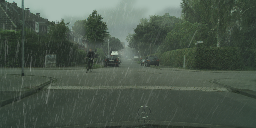
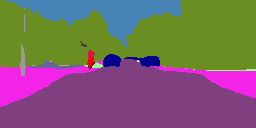
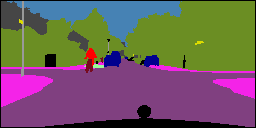

In [21]:
# Train the DeepLabV3+ model
print("Testing training process...")
trainer = Trainer(model, ds_split)
df_train, df_val = trainer.fit(epochs=40, batch_size=10)

from pathlib import Path
filepath = Path('df_train_crossEntropy_2.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train.to_csv(filepath)  

filepath = Path('df_val_crossEntropy_2.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_val.to_csv(filepath)  

# Save the trained model
torch.save(model.state_dict(), 'deeplabv3plus_2.pth')

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b:
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

**Fog**

In [22]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve


#shutil.rmtree('data')
# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209847'
dir_truth = os.path.join(dir_data, "fogtruth")

url_input = 'https://filesender.surf.nl/download.php?token=986159ae-fc42-453a-9171-c21352ada40b&files_ids=13213285'
dir_input = os.path.join(dir_data, "leftImg8bit_foggyDBF")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()

        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')

# Done!
print(f'All data downloaded')

Directory does not exist: /content/data/fogtruth
Downloading: https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209847
Progress: 100.00 %
Unpacking archive.
Directory does not exist: /content/data/leftImg8bit_foggyDBF
Downloading: https://filesender.surf.nl/download.php?token=986159ae-fc42-453a-9171-c21352ada40b&files_ids=13213285
Progress: 100.00 %
Unpacking archive.
All data downloaded


In [23]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue

    print(f'Preprocessing: {dir_full}')

    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue

        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')

        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)

        for f in files:
            if not f.endswith('.png'):
                continue

            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)

print(f'Preprocessing done')

Preprocessing: /content/data/fogtruth
Preprocessing sub-directory: /val/munster
Preprocessing sub-directory: /val/frankfurt
Preprocessing sub-directory: /val/lindau
Preprocessing sub-directory: /train/hanover
Preprocessing sub-directory: /train/cologne
Preprocessing sub-directory: /train/bochum
Preprocessing sub-directory: /train/darmstadt
Preprocessing sub-directory: /train/weimar
Preprocessing sub-directory: /train/hamburg
Preprocessing sub-directory: /train/zurich
Preprocessing sub-directory: /train/ulm
Preprocessing sub-directory: /train/aachen
Preprocessing sub-directory: /train/monchengladbach
Preprocessing sub-directory: /train/dusseldorf
Preprocessing sub-directory: /train/strasbourg
Preprocessing sub-directory: /train/bremen
Preprocessing sub-directory: /train/krefeld
Preprocessing sub-directory: /train/erfurt
Preprocessing sub-directory: /train/stuttgart
Preprocessing sub-directory: /train/tubingen
Preprocessing sub-directory: /train/jena
Preprocessing: /content/data/leftImg8

In [24]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    beta: str = ""


    @property
    def id(self):
      if self.beta != "":
          return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id, "leftImg8bit_foggy_beta", self.beta]))
      else:
          return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+)_leftImg8bit_foggy_beta_((\d+\.\d+)).*.png$", filename, re.I)
        if match != None:
             print("Yes",filename)
             return CityscapesSample(match.group(1), match.group(2), match.group(3),match.group(4))
        else:
            match = re.match(r"^(\w+)_(\d+)_(\d+)_.*.png$", filename, re.I)
            print("No",filename)
            return CityscapesSample(match.group(1), match.group(2), match.group(3))

# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str       # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    ID: int         # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    trainId: int    # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    category: str   # The name of the category that this label belongs to

    categoryId: int # The ID of this category. Used to create ground truth images
                    # on category level.

    hasInstances: bool # Whether this label distinguishes between single instances or not

    ignoreInEval: bool # Whether pixels having this class as ground truth label are ignored
                       # during evaluations or not

    color: Tuple[int, int, int]       # The color of this label


# List of classes that we want to detect in the input
classes = [
    #                 name                     ID    trainId   category            catId     hasInstances   ignoreInEval   color
    CityscapesClass(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    CityscapesClass(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    CityscapesClass(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    CityscapesClass(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    CityscapesClass(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    CityscapesClass(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    CityscapesClass(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    CityscapesClass(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    CityscapesClass(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    CityscapesClass(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    CityscapesClass(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    CityscapesClass(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    CityscapesClass(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    CityscapesClass(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (0  ,  0,  0) ),
    CityscapesClass(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    CityscapesClass(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    CityscapesClass(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    CityscapesClass(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    CityscapesClass(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    CityscapesClass(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    CityscapesClass(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    CityscapesClass(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    CityscapesClass(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    CityscapesClass(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    CityscapesClass(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    CityscapesClass(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    CityscapesClass(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    CityscapesClass(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    CityscapesClass(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    CityscapesClass(  'license plate'        , -1 ,      255 , 'vehicle'         , 7       , False        , True         , (0  ,0  ,  0) ),
]

In [28]:
import numpy as np
import os
import torchvision
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
import random

import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()

        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)
 
    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        # Data Argumentation
        if self.dir_input == os.path.join(dir_input_pp, 'train'):
            # Horizontal flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomHorizontalFlip(p=1)(img)
                mask = torchvision.transforms.RandomHorizontalFlip(p=1)(mask)
            
            # Vertical flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomVerticalFlip(p=1)(img)
                mask = torchvision.transforms.RandomVerticalFlip(p=1)(mask)
            
            # Random rotation
            if random.random() <= 0.3:
                angle = random.randint(-30, 30)
                img = torchvision.transforms.functional.rotate(img, angle)
                mask = torchvision.transforms.functional.rotate(mask, angle)
            
            # Brightness adjustment
            if random.random() <= 0.3:
                img = torchvision.transforms.functional.adjust_brightness(img, random.random() + 0.5)

            # Colour dithering
            if random.random() <= 0.3:
                color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
                img = color_jitter(img)
        ################################################################################# 
        # Convert the image to a tensor
        img = TF.to_tensor(img)

        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target[eq] = c.trainId    
            
        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val")
}


流式输出内容被截断，只能显示最后 5000 行内容。
Yes strasbourg_000000_032346_leftImg8bit_foggy_beta_0.02.png
Yes strasbourg_000000_000295_leftImg8bit_foggy_beta_0.005.png
Yes strasbourg_000000_030017_leftImg8bit_foggy_beta_0.005.png
Yes strasbourg_000001_003991_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000000_029481_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000000_017081_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000000_016436_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000001_006153_leftImg8bit_foggy_beta_0.02.png
Yes strasbourg_000000_017450_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000001_030269_leftImg8bit_foggy_beta_0.02.png
Yes strasbourg_000001_051661_leftImg8bit_foggy_beta_0.005.png
Yes strasbourg_000001_017675_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000001_016681_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000000_004951_leftImg8bit_foggy_beta_0.02.png
Yes strasbourg_000001_057191_leftImg8bit_foggy_beta_0.01.png
Yes strasbourg_000001_000778_leftImg8bit_foggy_beta_0.0

Testing training process...
Epoch 1


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.96it/s, accuracy=tensor(0.6369), loss=0.304]


Validation loss is 0.0023602729592058394, validation accuracy is 0.7378321290016174
Epoch 2


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.95it/s, accuracy=tensor(0.6469), loss=0.291]


Validation loss is 0.002472514773739709, validation accuracy is 0.7381681203842163
Epoch 3


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.88it/s, accuracy=tensor(0.6490), loss=0.299]

Validation loss is 0.002411869553062651, validation accuracy is 0.739627480506897
Epoch 4



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.02it/s, accuracy=tensor(0.6561), loss=0.279]


Validation loss is 0.0024420812586943307, validation accuracy is 0.7503573298454285
Epoch 5


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.47it/s, accuracy=tensor(0.6565), loss=0.27]

Validation loss is 0.0023769060446156396, validation accuracy is 0.748490035533905
Epoch 6



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.59it/s, accuracy=tensor(0.6617), loss=0.267]

Validation loss is 0.0025939512021011775, validation accuracy is 0.7455688714981079
Epoch 7



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.18it/s, accuracy=tensor(0.6470), loss=0.277]

Validation loss is 0.0024697899778683982, validation accuracy is 0.7478050589561462
Epoch 8



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.10it/s, accuracy=tensor(0.6634), loss=0.289]

Validation loss is 0.0024018281810813478, validation accuracy is 0.754080057144165
Epoch 9



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.97it/s, accuracy=tensor(0.6479), loss=0.3]


Validation loss is 0.0024500783999760944, validation accuracy is 0.7486727237701416
Epoch 10


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.64it/s, accuracy=tensor(0.6561), loss=0.294]

Validation loss is 0.002350128807624181, validation accuracy is 0.7564455270767212
Epoch 11



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.32it/s, accuracy=tensor(0.6583), loss=0.298]

Validation loss is 0.002339114786518945, validation accuracy is 0.7588387131690979
Epoch 12



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.88it/s, accuracy=tensor(0.6582), loss=0.289]

Validation loss is 0.0023144951780637107, validation accuracy is 0.7580273151397705
Epoch 13



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.37it/s, accuracy=tensor(0.6603), loss=0.285]

Validation loss is 0.002360297904411952, validation accuracy is 0.7575920820236206
Epoch 14



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.75it/s, accuracy=tensor(0.6628), loss=0.279]

Validation loss is 0.002386719071865082, validation accuracy is 0.7577624320983887
Epoch 15



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.12it/s, accuracy=tensor(0.6627), loss=0.275]

Validation loss is 0.0024015743427806433, validation accuracy is 0.7581403851509094
Epoch 16



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.60it/s, accuracy=tensor(0.6642), loss=0.274]


Validation loss is 0.0024294756836361355, validation accuracy is 0.7576608061790466
Epoch 17


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.17it/s, accuracy=tensor(0.6632), loss=0.29]


Validation loss is 0.0024108557641506195, validation accuracy is 0.7586497068405151
Epoch 18


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 50.76it/s, accuracy=tensor(0.6649), loss=0.287]


Validation loss is 0.0024361489441659715, validation accuracy is 0.7578402161598206
Epoch 19


Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.44it/s, accuracy=tensor(0.6644), loss=0.278]

Validation loss is 0.0024452359543906317, validation accuracy is 0.7575332522392273
Epoch 20



Validation: 100%|██████████| 1500/1500 [00:29<00:00, 51.06it/s, accuracy=tensor(0.6629), loss=0.276]


Validation loss is 0.0024785407496823206, validation accuracy is 0.7569215297698975


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 20, 128, 256]",
Target,"[128, 256]",

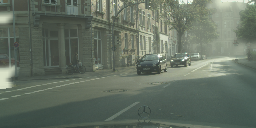
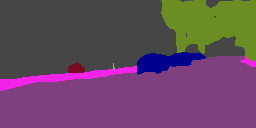
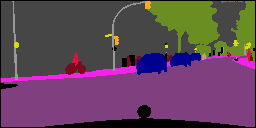

In [30]:
# Train the DeepLabV3+ model
print("Testing training process...")
trainer = Trainer(model, ds_split)
df_train, df_val = trainer.fit(epochs=20, batch_size=10)

from pathlib import Path
filepath = Path('df_train_crossEntropy_3.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train.to_csv(filepath)  

filepath = Path('df_val_crossEntropy_3.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_val.to_csv(filepath)  

# Save the trained model
torch.save(model.state_dict(), 'deeplabv3plus_3.pth')

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b:
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

**Snow**

In [31]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve


# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209839'
dir_truth = os.path.join(dir_data, "snowtruth")

url_input = 'https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209851'
dir_input = os.path.join(dir_data, "leftImg8bit_400_512")
# dir_data = "D:/荷兰/TUe/课程/Q3/5LSM0/Assignment 3/data/data"

# dir_truth = os.path.join(dir_data, "gtFine")
# dir_input = os.path.join(dir_data, "leftImg8bit")


# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()

        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')

# Done!
print(f'All data downloaded')


Directory does not exist: /content/data/snowtruth
Downloading: https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209839
Progress: 100.00 %
Unpacking archive.
Directory does not exist: /content/data/leftImg8bit_400_512
Downloading: https://filesender.surf.nl/download.php?token=70b03c8b-67fe-4a3f-9728-79997add31ca&files_ids=13209851
Progress: 100.00 %
Unpacking archive.
All data downloaded


In [32]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue

    print(f'Preprocessing: {dir_full}')

    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue

        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')

        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)

        for f in files:
            if not f.endswith('.png'):
                continue

            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)

print(f'Preprocessing done')

Preprocessing: /content/data/snowtruth
Preprocessing sub-directory: /val/munster
Preprocessing sub-directory: /val/frankfurt
Preprocessing sub-directory: /val/lindau
Preprocessing sub-directory: /train/hanover
Preprocessing sub-directory: /train/cologne
Preprocessing sub-directory: /train/bochum
Preprocessing sub-directory: /train/darmstadt
Preprocessing sub-directory: /train/weimar
Preprocessing sub-directory: /train/hamburg
Preprocessing sub-directory: /train/zurich
Preprocessing sub-directory: /train/ulm
Preprocessing sub-directory: /train/aachen
Preprocessing sub-directory: /train/monchengladbach
Preprocessing sub-directory: /train/dusseldorf
Preprocessing sub-directory: /train/strasbourg
Preprocessing sub-directory: /train/bremen
Preprocessing sub-directory: /train/krefeld
Preprocessing sub-directory: /train/erfurt
Preprocessing sub-directory: /train/stuttgart
Preprocessing sub-directory: /train/tubingen
Preprocessing sub-directory: /train/jena
Preprocessing: /content/data/leftImg

In [33]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str

    @property
    def id(self):
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id,"leftImg8bit"]))

    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)
        return CityscapesSample(match.group(1), match.group(2), match.group(3))


# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str       # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    ID: int         # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    trainId: int    # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    category: str   # The name of the category that this label belongs to

    categoryId: int # The ID of this category. Used to create ground truth images
                    # on category level.

    hasInstances: bool # Whether this label distinguishes between single instances or not

    ignoreInEval: bool # Whether pixels having this class as ground truth label are ignored
                       # during evaluations or not

    color: Tuple[int, int, int]       # The color of this label


# List of classes that we want to detect in the input
classes = [
    #                 name                     ID    trainId   category            catId     hasInstances   ignoreInEval   color
    CityscapesClass(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    CityscapesClass(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    CityscapesClass(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    CityscapesClass(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    CityscapesClass(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    CityscapesClass(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    CityscapesClass(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    CityscapesClass(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    CityscapesClass(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    CityscapesClass(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    CityscapesClass(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    CityscapesClass(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    CityscapesClass(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    CityscapesClass(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    CityscapesClass(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (0  ,  0,  0) ),
    CityscapesClass(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    CityscapesClass(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    CityscapesClass(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    CityscapesClass(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    CityscapesClass(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    CityscapesClass(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    CityscapesClass(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    CityscapesClass(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    CityscapesClass(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    CityscapesClass(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    CityscapesClass(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    CityscapesClass(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    CityscapesClass(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    CityscapesClass(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    CityscapesClass(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    CityscapesClass(  'license plate'        , -1 ,      255 , 'vehicle'         , 7       , False        , True         , (0  ,0  ,  0) ),
]

In [34]:
import numpy as np
import os
import torchvision
from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List
import random

import torchvision.transforms.functional as TF

class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"

    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample]):
        super().__init__()

        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> (torch.Tensor, torch.Tensor):
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)

    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> (torch.Tensor, torch.Tensor):
        ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        # Data Argumentation
        if self.dir_input == os.path.join(dir_input_pp, 'train'):
            # Horizontal flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomHorizontalFlip(p=1)(img)
                mask = torchvision.transforms.RandomHorizontalFlip(p=1)(mask)
            
            # Vertical flip
            if random.random() <= 0.3:
                img = torchvision.transforms.RandomVerticalFlip(p=1)(img)
                mask = torchvision.transforms.RandomVerticalFlip(p=1)(mask)
            
            # Random rotation
            if random.random() <= 0.3:
                angle = random.randint(-30, 30)
                img = torchvision.transforms.functional.rotate(img, angle)
                mask = torchvision.transforms.functional.rotate(mask, angle)
            
            # Brightness adjustment
            if random.random() <= 0.3:
                img = torchvision.transforms.functional.adjust_brightness(img, random.random() + 0.5)

            # Colour dithering
            if random.random() <= 0.3:
                color_jitter = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
                img = color_jitter(img)
        ################################################################################# 
        # Convert the image to a tensor
        img = TF.to_tensor(img)

        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target[eq] = c.trainId    
            
        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(lbl.trainId)

            target[0][eq] = lbl.color[0]
            target[1][eq] = lbl.color[1]
            target[2][eq] = lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')

# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes)
    for name in ("train", "val")
}


Testing training process...
Epoch 1


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.46it/s, accuracy=tensor(0.6724), loss=0.461]

Validation loss is 0.007335408699512481, validation accuracy is 0.7359164357185364
Epoch 2



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.53it/s, accuracy=tensor(0.6807), loss=0.498]

Validation loss is 0.007102976596355438, validation accuracy is 0.7411985993385315
Epoch 3



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.02it/s, accuracy=tensor(0.6677), loss=0.508]

Validation loss is 0.0073040669202804566, validation accuracy is 0.7398744225502014
Epoch 4



Validation: 100%|██████████| 500/500 [00:09<00:00, 50.70it/s, accuracy=tensor(0.6543), loss=0.465]


Validation loss is 0.007033702152967452, validation accuracy is 0.7421818375587463
Epoch 5


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.36it/s, accuracy=tensor(0.6876), loss=0.425]

Validation loss is 0.007090682911872865, validation accuracy is 0.7414032220840454
Epoch 6



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.68it/s, accuracy=tensor(0.6797), loss=0.435]

Validation loss is 0.006860563892126084, validation accuracy is 0.7475507259368896
Epoch 7



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.86it/s, accuracy=tensor(0.6760), loss=0.43]

Validation loss is 0.007162906092405319, validation accuracy is 0.7469081282615662
Epoch 8



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.37it/s, accuracy=tensor(0.6827), loss=0.353]

Validation loss is 0.007128197282552719, validation accuracy is 0.7462422251701355
Epoch 9



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.91it/s, accuracy=tensor(0.7008), loss=0.388]

Validation loss is 0.007113168603181838, validation accuracy is 0.7478542327880859
Epoch 10



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.81it/s, accuracy=tensor(0.6780), loss=0.417]

Validation loss is 0.007008859848976135, validation accuracy is 0.7513957023620605
Epoch 11



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.27it/s, accuracy=tensor(0.6719), loss=0.46]


Validation loss is 0.007278332310914994, validation accuracy is 0.7479138970375061
Epoch 12


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.52it/s, accuracy=tensor(0.6755), loss=0.425]


Validation loss is 0.006868373072147369, validation accuracy is 0.7477303147315979
Epoch 13


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.40it/s, accuracy=tensor(0.6742), loss=0.43]


Validation loss is 0.007061998528242111, validation accuracy is 0.7475883960723877
Epoch 14


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.03it/s, accuracy=tensor(0.6779), loss=0.396]


Validation loss is 0.006880837649106979, validation accuracy is 0.7526043653488159
Epoch 15


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.05it/s, accuracy=tensor(0.6850), loss=0.407]

Validation loss is 0.006944413965940476, validation accuracy is 0.7523157000541687
Epoch 16



Validation: 100%|██████████| 500/500 [00:09<00:00, 51.19it/s, accuracy=tensor(0.6876), loss=0.409]


Validation loss is 0.0068918274641037, validation accuracy is 0.7536327838897705
Epoch 17


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.37it/s, accuracy=tensor(0.6823), loss=0.444]


Validation loss is 0.006927084016799927, validation accuracy is 0.753268837928772
Epoch 18


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.59it/s, accuracy=tensor(0.6827), loss=0.433]


Validation loss is 0.006951720196008683, validation accuracy is 0.7537345886230469
Epoch 19


Validation: 100%|██████████| 500/500 [00:09<00:00, 50.97it/s, accuracy=tensor(0.6877), loss=0.443]


Validation loss is 0.006942585307359695, validation accuracy is 0.7549293637275696
Epoch 20


Validation: 100%|██████████| 500/500 [00:09<00:00, 51.86it/s, accuracy=tensor(0.6842), loss=0.424]


Validation loss is 0.006985404956340789, validation accuracy is 0.7545174360275269


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 20, 128, 256]",
Target,"[128, 256]",

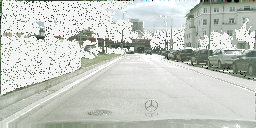
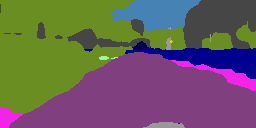
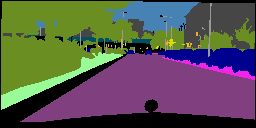

In [35]:
# Train the DeepLabV3+ model
print("Testing training process...")
trainer = Trainer(model, ds_split)
df_train, df_val = trainer.fit(epochs=20, batch_size=10)

from pathlib import Path
filepath = Path('df_train_crossEntropy_4.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_train.to_csv(filepath)  

filepath = Path('df_val_crossEntropy_4.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df_val.to_csv(filepath)  

# Save the trained model
torch.save(model.state_dict(), 'deeplabv3plus_4.pth')

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b:
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Validate your baseline on the competition server
For the final assignment you need to upload your model on our [competition server](https://codalab.lisn.upsaclay.fr/competitions/11173#learn_the_details). You can already test your current baseline with Phase 1. We recommend you to do this, because this gives you a head start for the final assignment.

## Questions
Please answer all question in this template. Note we don't expect experiments to support your answers, but take these questions in consideration for the final assignment.

1) Give two suggestions on how to improve the segmentation performance on specific classes?

Data Augmentation

It will help a lot to improve the segmentation performance. Doing augmentation like rotating, changing brightness or shifting will help model to learn more about image segmentation.

Pre-trained models

We can improve the performance by pre-training the model on a large dataset like ImageNet and then fine tuning the model for our classes.

Atrous convolution

The reduction of the feature map is caused by pooling. In order to ensure a certain accuracy of the feature map, can we not use or reduce the use of pooling? It is theoretically feasible, but if doing so will make too many parameters need to be optimized, the important thing is that it is difficult to perform fine-tuning based on the previous model, atrous convolution solves this problem.
In DeepLab, set the stride=1 of pool4 and pool5, plus 1 padding, so that the size of the feature map remains unchanged after pooling, but the receptive field of the back layer has changed. In order to keep the receptive field unchanged, the convolutional layer behind Using atrous convolution, its function is to increase the receptive field without increasing the parameters. Therefore, the problem of decreased spatial resolution of the feature map is solved.


2) How do you ensure your model does not overfit on the training set?

I checked whether the model is overfitting by plotting the validation loss and training loss. When the model gets overfitted the validation loss will become significantly higher than training loss. 

Use L1/L2 regularization

Use the Dropout trick when training the network

3) What is the disadvantage of reporting just the average IoU over all classes?

Equal importance for all classes: It doesn't give any importance to any class. All classes are treated equal. It gives equal importance to classes having large number of samples and small number of samples in the dataset. To assign more significance to specific classes in a given application, using the average IoU score across all classes is not adequate. To achieve the best results, each class must have an equal number of samples.

Concealed inefficiency: Even if some classes have low scores, the model's overall score may still be high if other classes have high scores. This may result in low-scoring classes being overlooked in the model.  

4) Come up with 2 ideas to test your models on robustness in terms of lesser input quality and generalization?

Data Augmentation: Various data augmentation techniques such as rotation, scaling, flipping, translation and color perturbation are applied on the test set. This simulates various scenarios that the model might encounter in real-world applications and helps to evaluate the model's ability to generalize its response to these changes.

Cross-domain testing: We can test the model with datasets that are very different from training dataset. If our training dataset contains images taken from countries that follow left-hand traffic laws, we can test them on the images taken from countries that follow right-hand traffic laws. 

## Troubleshooting

###### There is not enough memory on my GPU to define any practical network.
We already downsampled the images in the preprocessing section of the notebook. Before downsampling further, try reducing your `batch_size` on the `Trainer` class.

###### My assignment partner keeps overwriting my changes
Consider splitting up the notebook and your networks into multiple python files and using a Git repository for version control.

###### There is not enough memory on my PC to store the dataset
Connect a USB-drive and point the `dir_data` variable to this location.

_Created by Kurt Stolle, last modified 2021-03-14_